In [1]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [88]:
data_dir = os.getcwd() + '/yelp_dataset'
data = pd.read_pickle(os.path.join(data_dir, 'features.pkl'))
data.columns

Index(['address', 'attributes', 'business_id', 'categories', 'city', 'hours',
       'is_open', 'latitude', 'longitude', 'name', 'postal_code',
       'review_count', 'stars', 'state', 'population', 'population_density',
       'land_area_in_sqmi', 'median_household_income', 'cool', 'funny',
       'useful', 'avg_stars_review', 'review_start_year', 'review_start_month',
       'review_latest_year', 'review_latest_month', 'review_duration',
       'review_per_month', 'checkin_duration', 'checkin_start_year',
       'checkin_start_month', 'checkin_latest_year', 'checkin_latest_month',
       'checkin_count', 'checkin_per_month', 'coords_cluster_label',
       'neighbors', 'is_chain'],
      dtype='object')

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [89]:
def prepare_data(data):
    drop_list = ['address', 'attributes', 'business_id', 'categories', 'city', 'hours',
                 'latitude', 'longitude', 'name', 'postal_code', 'state', 'stars',
                 'review_start_month', 'review_latest_month', 'checkin_start_month', 'checkin_latest_month']
    data = data.drop(columns=drop_list).dropna()
    data = data.replace([np.inf, -np.inf], 0)
    X = data.drop(columns='is_open')
    y = data['is_open']
    
    return X, y
X, y = prepare_data(data_sampled)

## Logistic Regression

In [90]:
# initial logistic regression model
lr = LogisticRegression(solver='liblinear', max_iter=1000)
# fit the model
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
# classification results
print('Logistic regression score for training set: %f' % lr.score(X_train, y_train))
print('Logistic regression score for testing set: %f' % lr.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Logistic regression score for training set: 0.715360
Logistic regression score for testing set: 0.716040
              precision    recall  f1-score   support

           0       0.71      0.70      0.70      4372
           1       0.72      0.73      0.73      4668

    accuracy                           0.72      9040
   macro avg       0.72      0.72      0.72      9040
weighted avg       0.72      0.72      0.72      9040



## lightGBM

In [54]:
import lightgbm as lgb

lightGBM score for training set: 0.922846
lightGBM score for testing set: 0.888385
-----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      4372
           1       0.87      0.92      0.90      4668

    accuracy                           0.89      9040
   macro avg       0.89      0.89      0.89      9040
weighted avg       0.89      0.89      0.89      9040



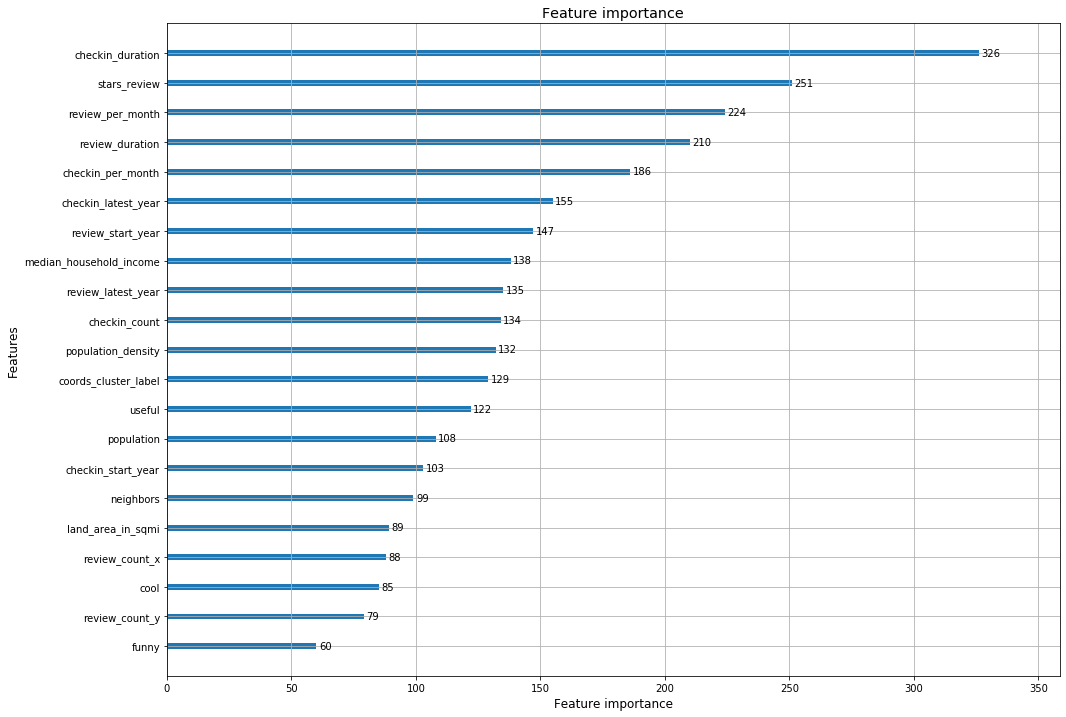

In [91]:
def lightgbm_model(X, y):
    # split the data into test and training sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=21)
    # initialize lightGBM mdoel
    lgb_model = lgb.LGBMClassifier()
    # fit the model
    lgb_model.fit(X_train, y_train)
    y_pred = lgb_model.predict(X_test)
    # results
    print('lightGBM score for training set: %f' % lgb_model.score(X_train, y_train))
    print('lightGBM score for testing set: %f' % lgb_model.score(X_test, y_test))
    print('-----------------------------------------------------------')
    print(classification_report(y_test, y_pred))
    fig, axes = plt.subplots()
    fig.set_size_inches(16, 12)
    lgb.plot_importance(lgb_model, ax=axes)
    plt.show()
    
lightgbm_model(X, y)

## Test business unprocessed data

In [63]:
print('Loading business data ...')
df_business = pd.read_json(os.path.join(data_dir, 'business.json'), lines=True)
print('Done!')

Loading business data ...
Done!


In [67]:
df_business.columns
drop_list_business = ['address', 'attributes', 'business_id', 'categories', 'city', 'hours',
                      'latitude', 'longitude', 'name', 'postal_code', 'state']
data_business = df_business.drop(columns=drop_list_business)
sub_data_business = data_business[data_business['is_open']==1].sample(frac=0.2, random_state=21)
data_sampled_business = pd.concat([sub_data_business, data_business[data_business['is_open']==0]])

lightGBM score for training set: 0.589319
lightGBM score for testing set: 0.577081
              precision    recall  f1-score   support

           0       0.57      0.76      0.65     11217
           1       0.60      0.38      0.46     10494

    accuracy                           0.58     21711
   macro avg       0.58      0.57      0.56     21711
weighted avg       0.58      0.58      0.56     21711



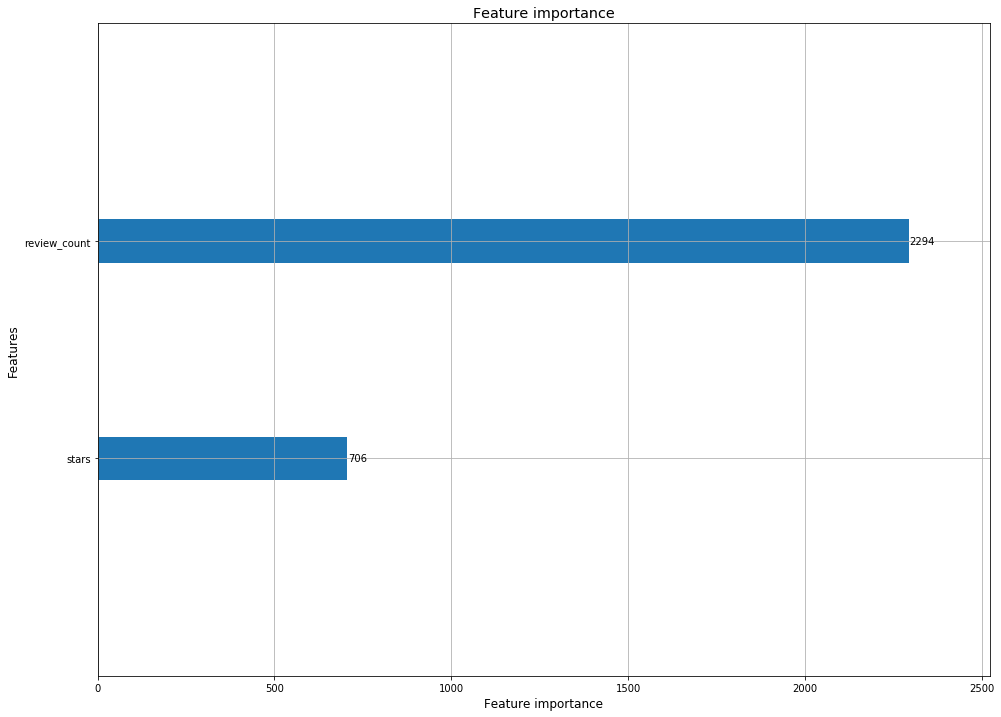

In [72]:
X_b, y_b = data_sampled_business.drop(columns='is_open'), data_sampled_business['is_open']
lightgbm_model(X_b, y_b)